# Import Dependencies

Begin by importing the necessary libraries

In [1]:
# Data storage
from google.cloud import bigquery

# Data analysis
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style('darkgrid')

# Data Exploration

Explore the StackOverflow dataset from BigQuery's public data archives

In [2]:
# Initialize a client object to project ID
project_id = 'trim-axle-358009'
client = bigquery.Client(project=project_id)

# Construct a reference to the "stackoverflow" dataset
dataset_ref = client.dataset('stackoverflow', project='bigquery-public-data')

# API request - fetch the dataset
dataset = client.get_dataset(dataset_ref)

In [3]:
# Print every table ID in the dataset
tables = list(client.list_tables(dataset))
for table in tables:  
    print(table.table_id)

badges
comments
post_history
post_links
posts_answers
posts_moderator_nomination
posts_orphaned_tag_wiki
posts_privilege_wiki
posts_questions
posts_tag_wiki
posts_tag_wiki_excerpt
posts_wiki_placeholder
stackoverflow_posts
tags
users
votes


# Question Prompt
Have posts (questions & answers) on StackOverflow been declining since 2014?

In [4]:
# Query to select question & answer counts as a function of time
query = """
        WITH q AS (
            SELECT EXTRACT(YEAR FROM creation_date) AS year, COUNT(*) AS num_questions
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            GROUP BY year
        ), 
        a AS (
            SELECT EXTRACT(YEAR FROM creation_date) AS year, COUNT(*) AS num_answers
            FROM `bigquery-public-data.stackoverflow.posts_answers`
            GROUP BY year
        ),
        cte AS (
            SELECT year, num_questions, num_answers,
            FROM q
            JOIN a
                USING(year)
        )
        SELECT 
            c1.year, 
            c1.num_questions,
            ROUND((c1.num_questions - c2.num_questions) / c1.num_questions * 100, 2) AS q_percent_diff,
            c1.num_answers, 
            ROUND((c1.num_answers - c2.num_answers) / c1.num_answers * 100, 2) AS a_percent_diff,
        FROM cte AS c1
        LEFT JOIN cte AS c2
            ON c1.year = c2.year + 1
        ORDER BY c1.year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,year,num_questions,q_percent_diff,num_answers,a_percent_diff
0,2008,57755,NaN,211257,NaN
1,2009,342050,83.12,934545,77.39
2,2010,691449,50.53,1458782,35.94
3,2011,1191023,41.94,2266467,35.64
4,2012,1630810,26.97,2826166,19.80
5,2013,2038409,20.00,3318779,14.84
6,2014,2141890,4.83,3199651,-3.72
7,2015,2198514,2.58,3146217,-1.70
8,2016,2202647,0.19,3074946,-2.32
9,2017,2118252,-3.98,2906866,-5.78


In [5]:
# drop 2022 data since it's incomplete
df.drop(index=14, inplace=True)

<Figure size 432x288 with 0 Axes>

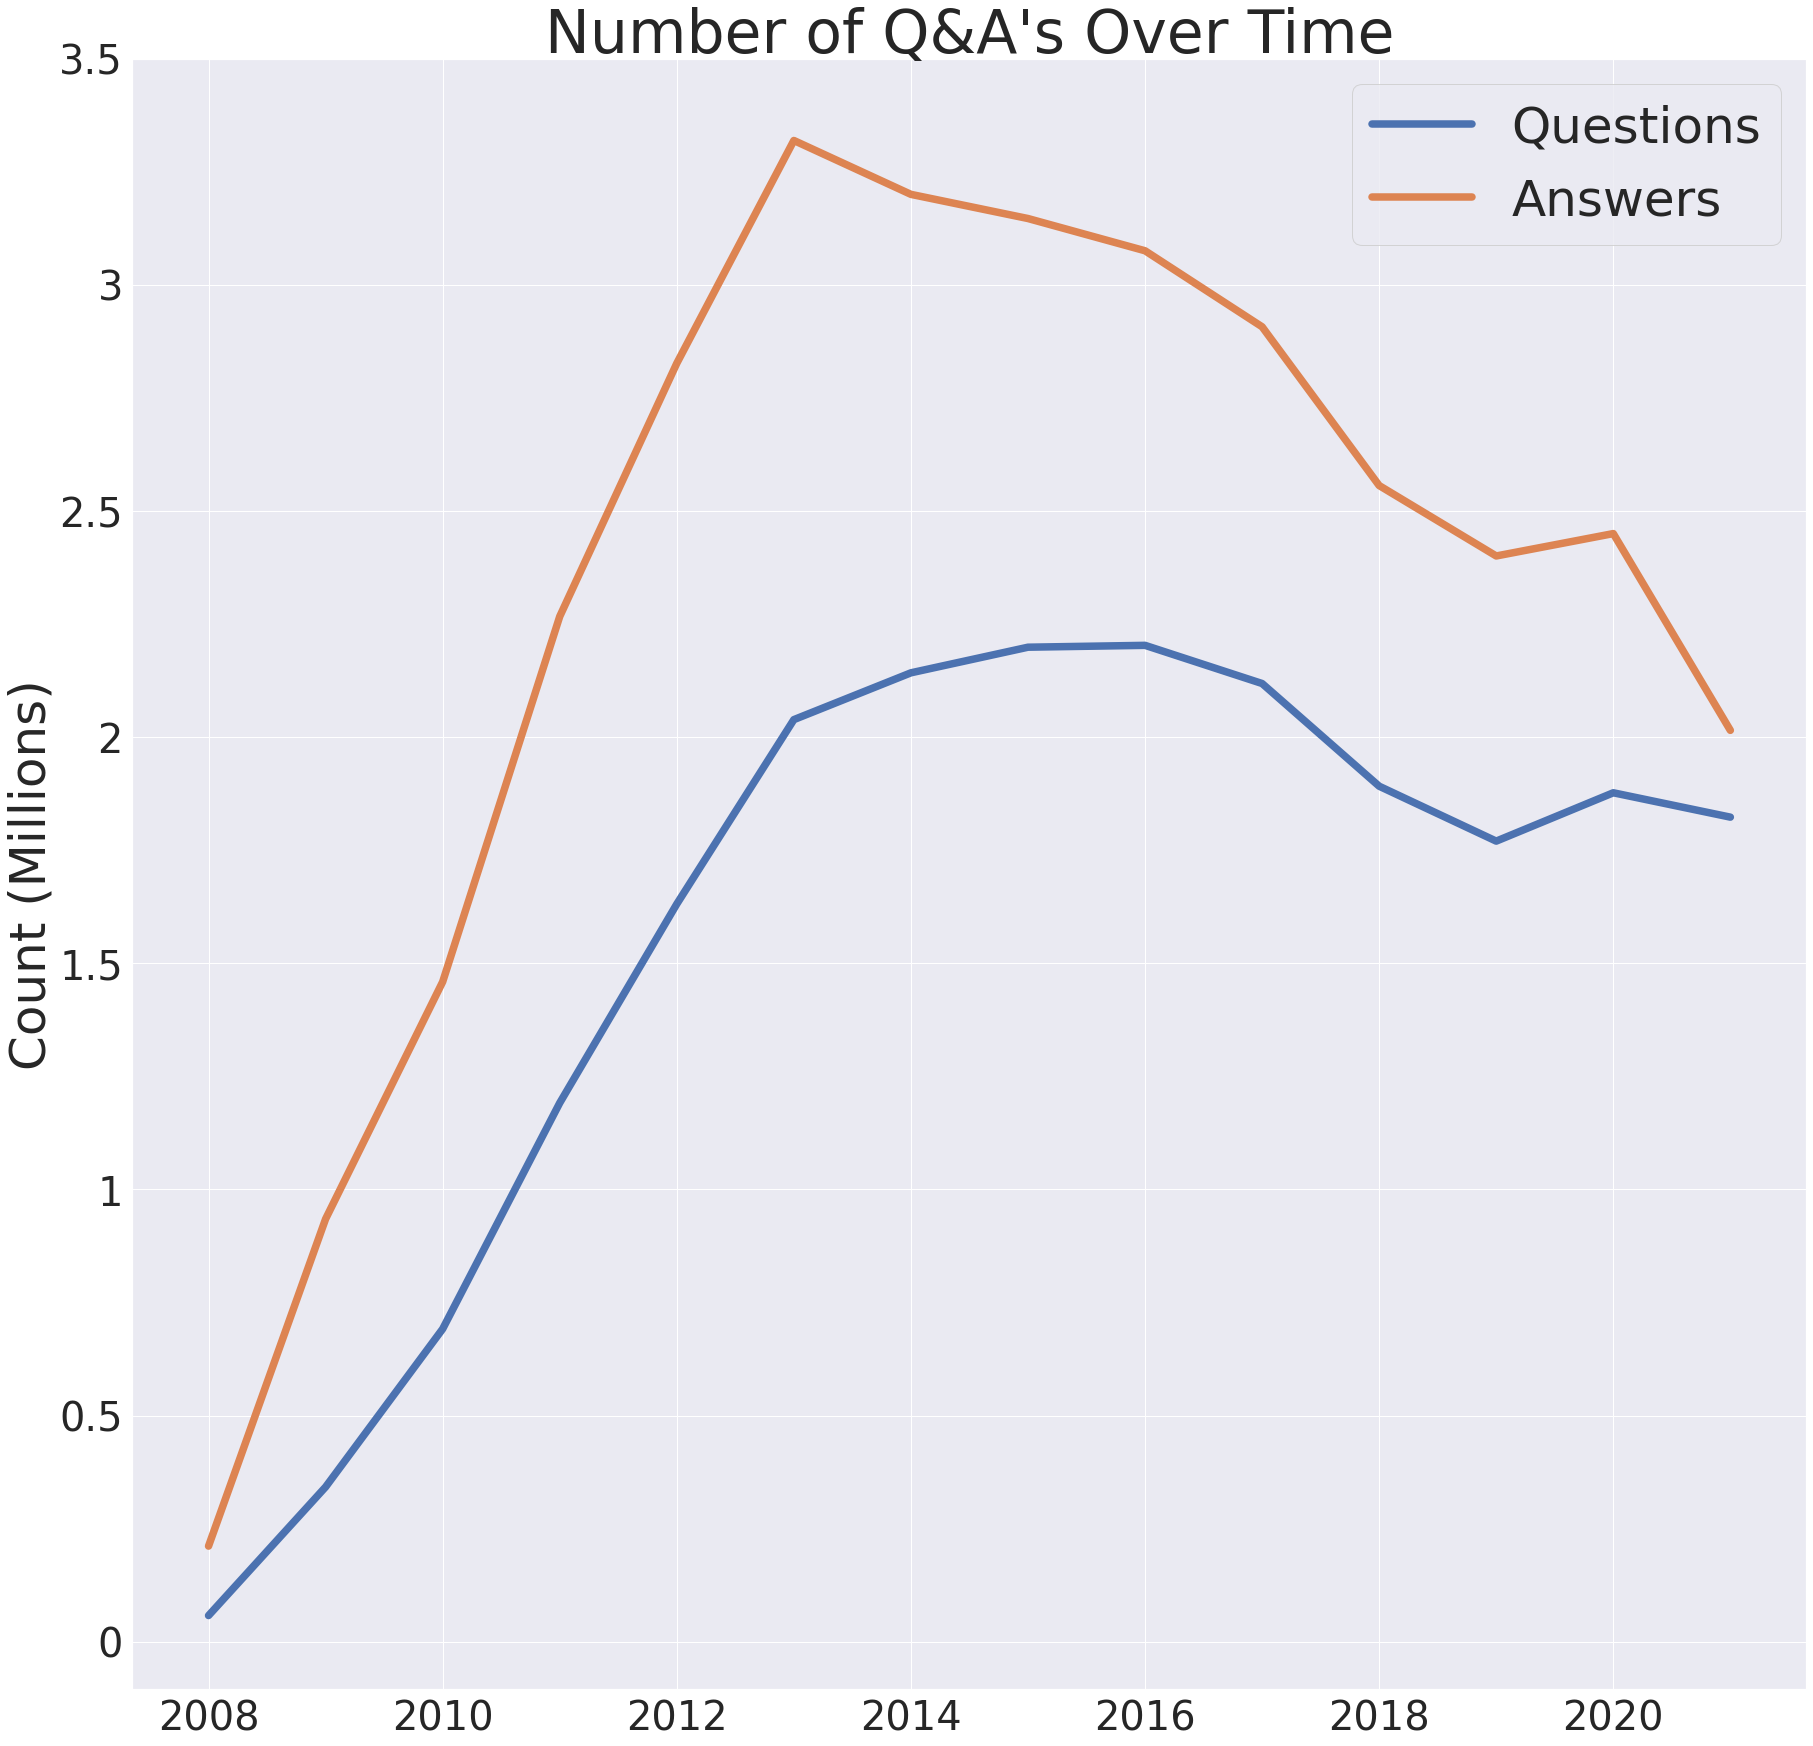

In [6]:
# Make line plot
fig = plt.figure()
ax = df.plot(x='year', y=['num_questions', 'num_answers'], kind='line', linewidth = 7.5, figsize=(30, 30), fontsize=40)

# Customize plot
ax.set_title('Number of Q&A\'s Over Time', fontsize=60)
ax.set_xlabel('')
ax.set_ylabel('Count (Millions)', fontsize=50)
ax.set_yticks(ticks=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000], labels=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
ax.legend(['Questions', 'Answers'], fontsize=50)

# Save plot
plt.savefig('num_qna.png')

<Figure size 432x288 with 0 Axes>

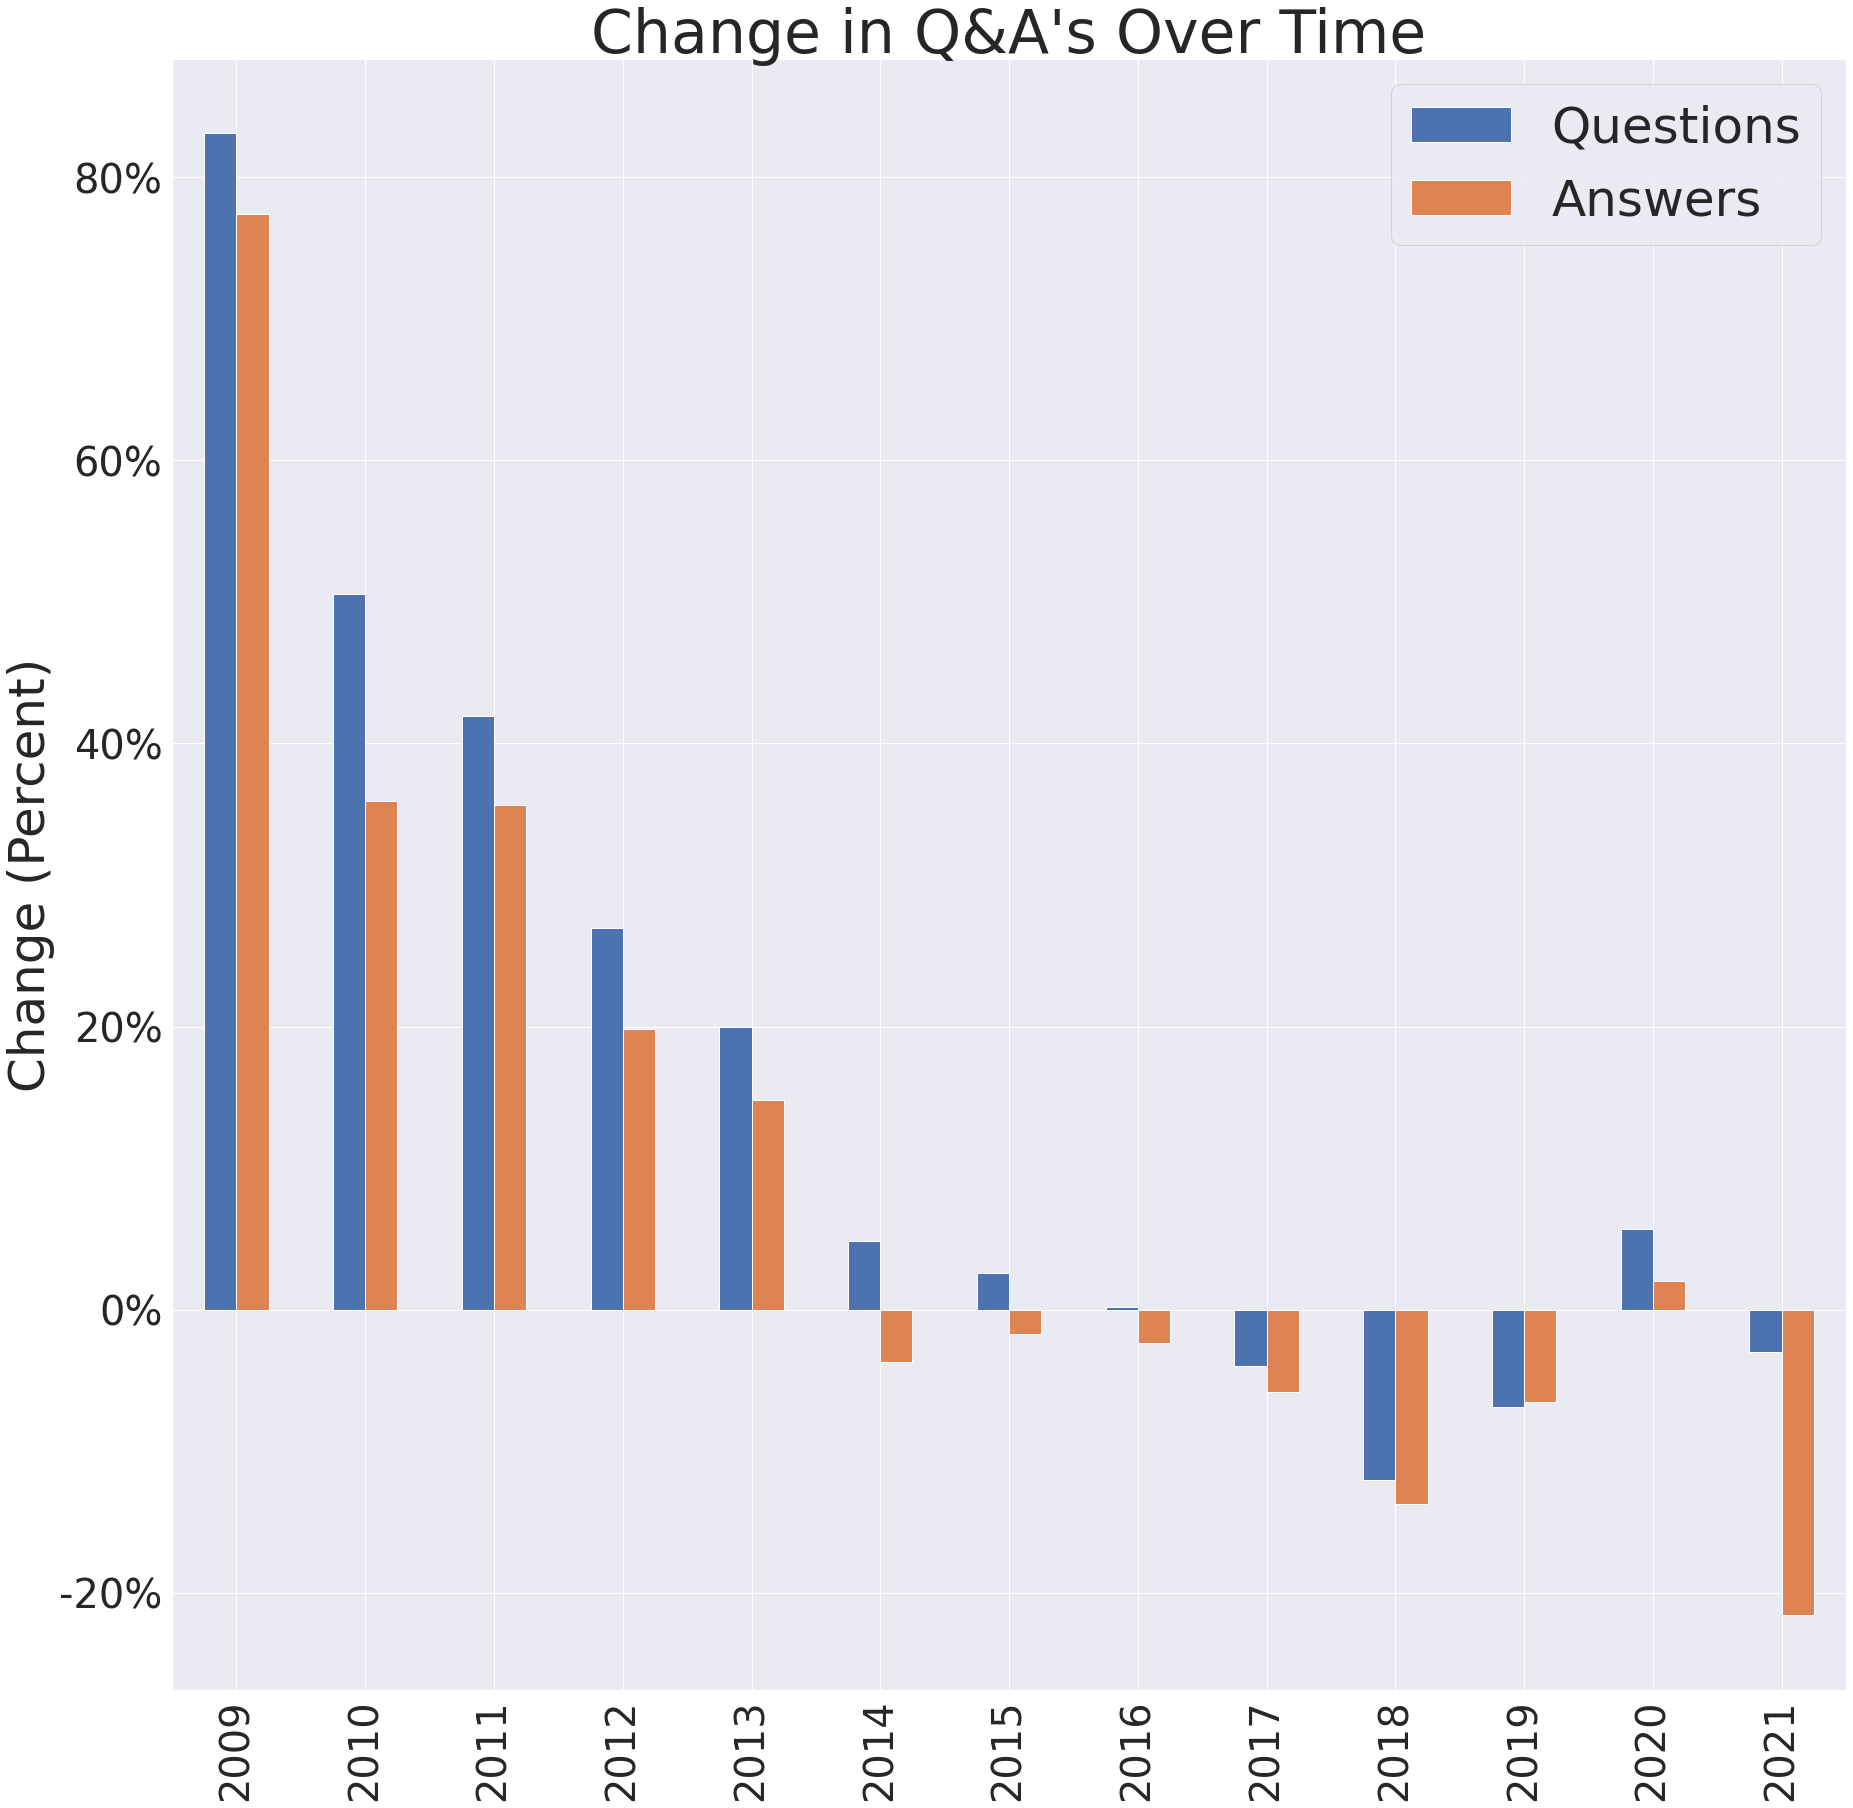

In [7]:
# Drop 2008 data since there's no change
df.drop(index=0, inplace=True)

# Make bar plot
fig = plt.figure()
ax = df.plot(x='year', y=['q_percent_diff', 'a_percent_diff'], kind='bar', figsize=(30, 30), fontsize=40)

# Customize plot
ax.set_title('Change in Q&A\'s Over Time', fontsize=60)
ax.set_xlabel('')
ax.set_ylabel('Change (Percent)', fontsize=50)
ax.set_yticks(ticks=[-20, 0, 20, 40, 60, 80], labels=['-20%', '0%', '20%', '40%', '60%', '80%'])
ax.legend(['Questions', 'Answers'], fontsize=50)

# Save plot
plt.savefig('qna_change.png')

# Root Cause Analysis

### 1. Low-hanging fruit 

One possible explanation is that the "easy" questions have already been asked, e.g. "how to make a plot in Python", "how to read a csv file in Pandas", "how to use SELECT statement in MySQL", etc.

In [8]:
# Query to select most asked about technologies from 2008 to 2014
query = """
        WITH cte_1 AS (
            SELECT
                SPLIT(tags,'|') AS tech_name
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            WHERE EXTRACT(YEAR FROM creation_date) >= 2008 AND EXTRACT(YEAR FROM creation_date) <= 2014
        ),
        cte_2 AS (
            SELECT
              tags,
              COUNT(*) AS num_questions
            FROM cte_1
            CROSS JOIN UNNEST(tech_name) AS tags
            GROUP BY tags
            ORDER BY num_questions DESC
            LIMIT 10
        )
        SELECT 
            tags,
            num_questions,
            ROUND(num_questions / SUM(num_questions) OVER() * 100, 2) AS percent_share
        FROM cte_2
        ORDER BY num_questions DESC
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,tags,num_questions,percent_share
0,java,733092,13.90
1,javascript,721710,13.68
2,c#,707171,13.41
3,php,645880,12.24
4,android,562103,10.66
5,jquery,536574,10.17
6,html,401257,7.61
7,python,360522,6.83
8,c++,326102,6.18
9,ios,280845,5.32


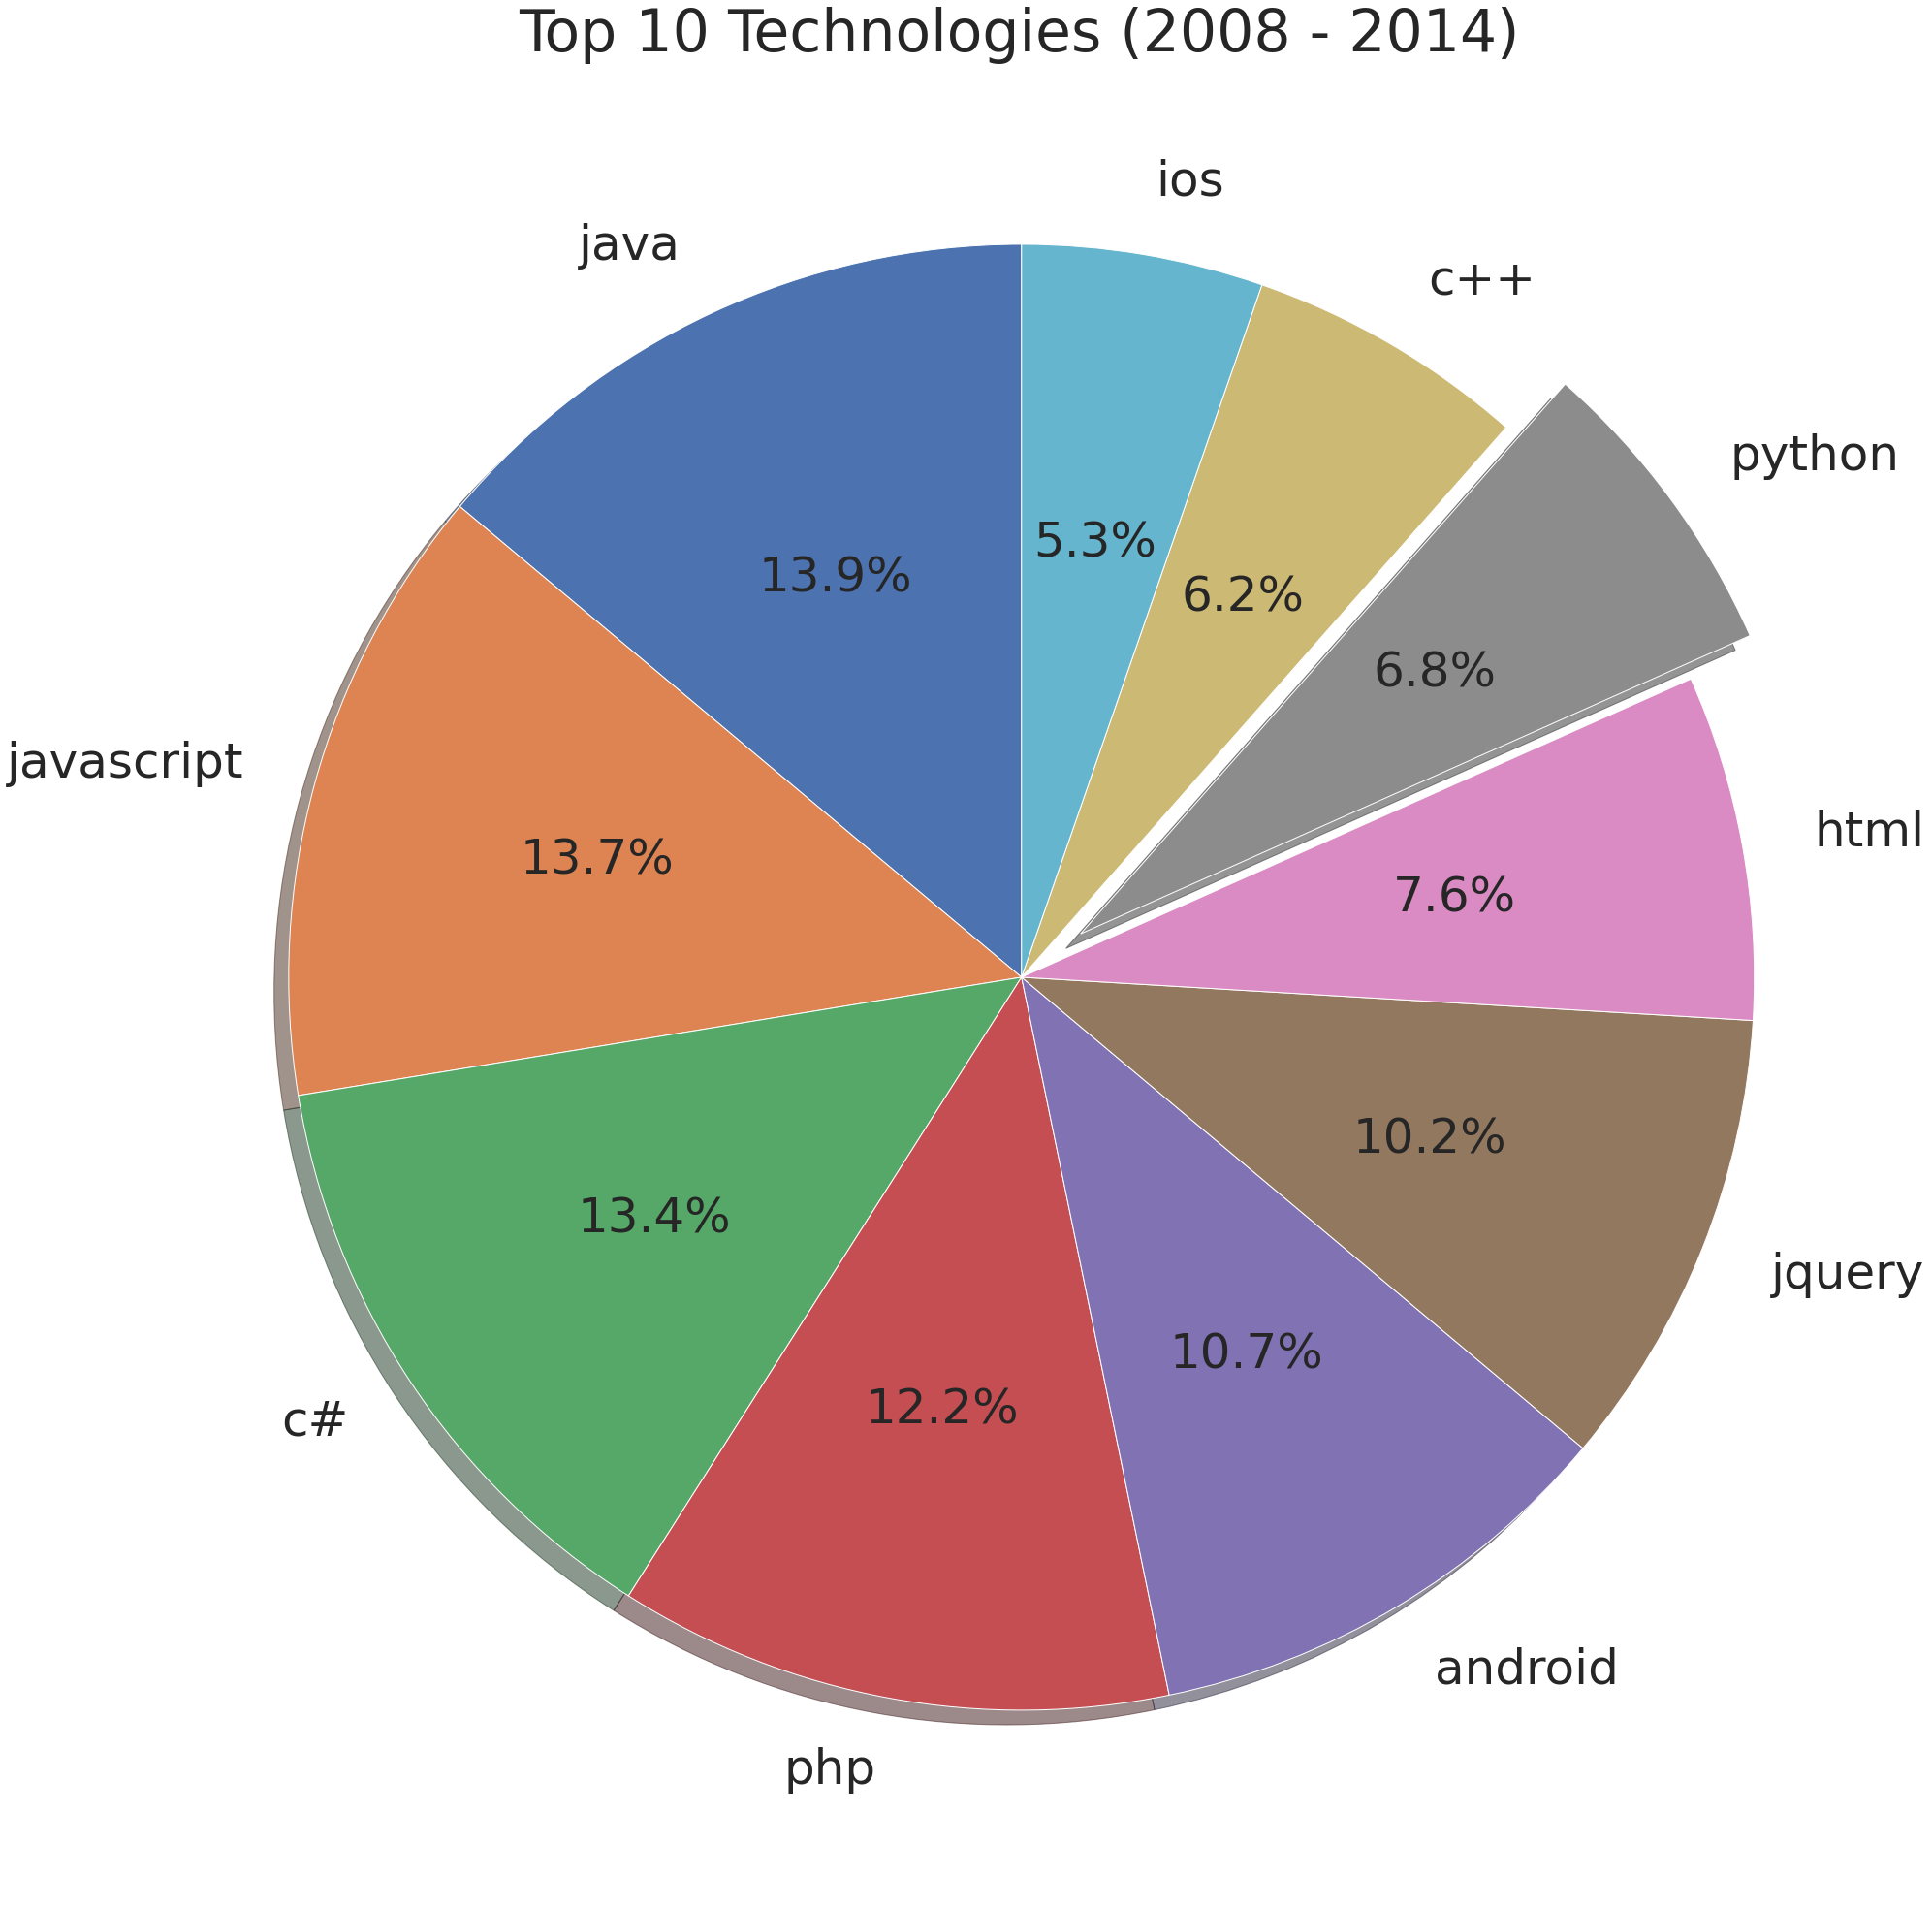

In [9]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.tags
sizes = df.percent_share

# "Explode" the 2nd slice (i.e. 'Python')
explode = (0, 0, 0, 0, 0, 0, 0, 0.1, 0, 0) 

# Make pie chart
fig1, ax = plt.subplots(figsize=(30, 35))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 50})

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Customize plot
ax.set_title('Top 10 Technologies (2008 - 2014)', fontsize=60)

# Save plot
plt.savefig('tech_distribution_2008.png')

In [10]:
# Query to select most asked about technologies from 2015 to 2022
query = """
        WITH cte_1 AS (
            SELECT
                SPLIT(tags,'|') AS tech_name
            FROM `bigquery-public-data.stackoverflow.posts_questions`
            WHERE EXTRACT(YEAR FROM creation_date) >= 2015 AND EXTRACT(YEAR FROM creation_date) <= 2022
        ),
        cte_2 AS (
            SELECT
              tags,
              COUNT(*) AS num_questions
            FROM cte_1
            CROSS JOIN UNNEST(tech_name) AS tags
            GROUP BY tags
            ORDER BY num_questions DESC
            LIMIT 10
        )
        SELECT 
            tags,
            num_questions,
            ROUND(num_questions / SUM(num_questions) OVER() * 100, 2) AS percent_share
        FROM cte_2
        ORDER BY num_questions DESC
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,tags,num_questions,percent_share
0,javascript,1621864,18.48
1,python,1541594,17.56
2,java,1097784,12.51
3,c#,818277,9.32
4,android,804508,9.17
5,php,783968,8.93
6,html,715572,8.15
7,jquery,487184,5.55
8,css,476090,5.42
9,c++,430369,4.90


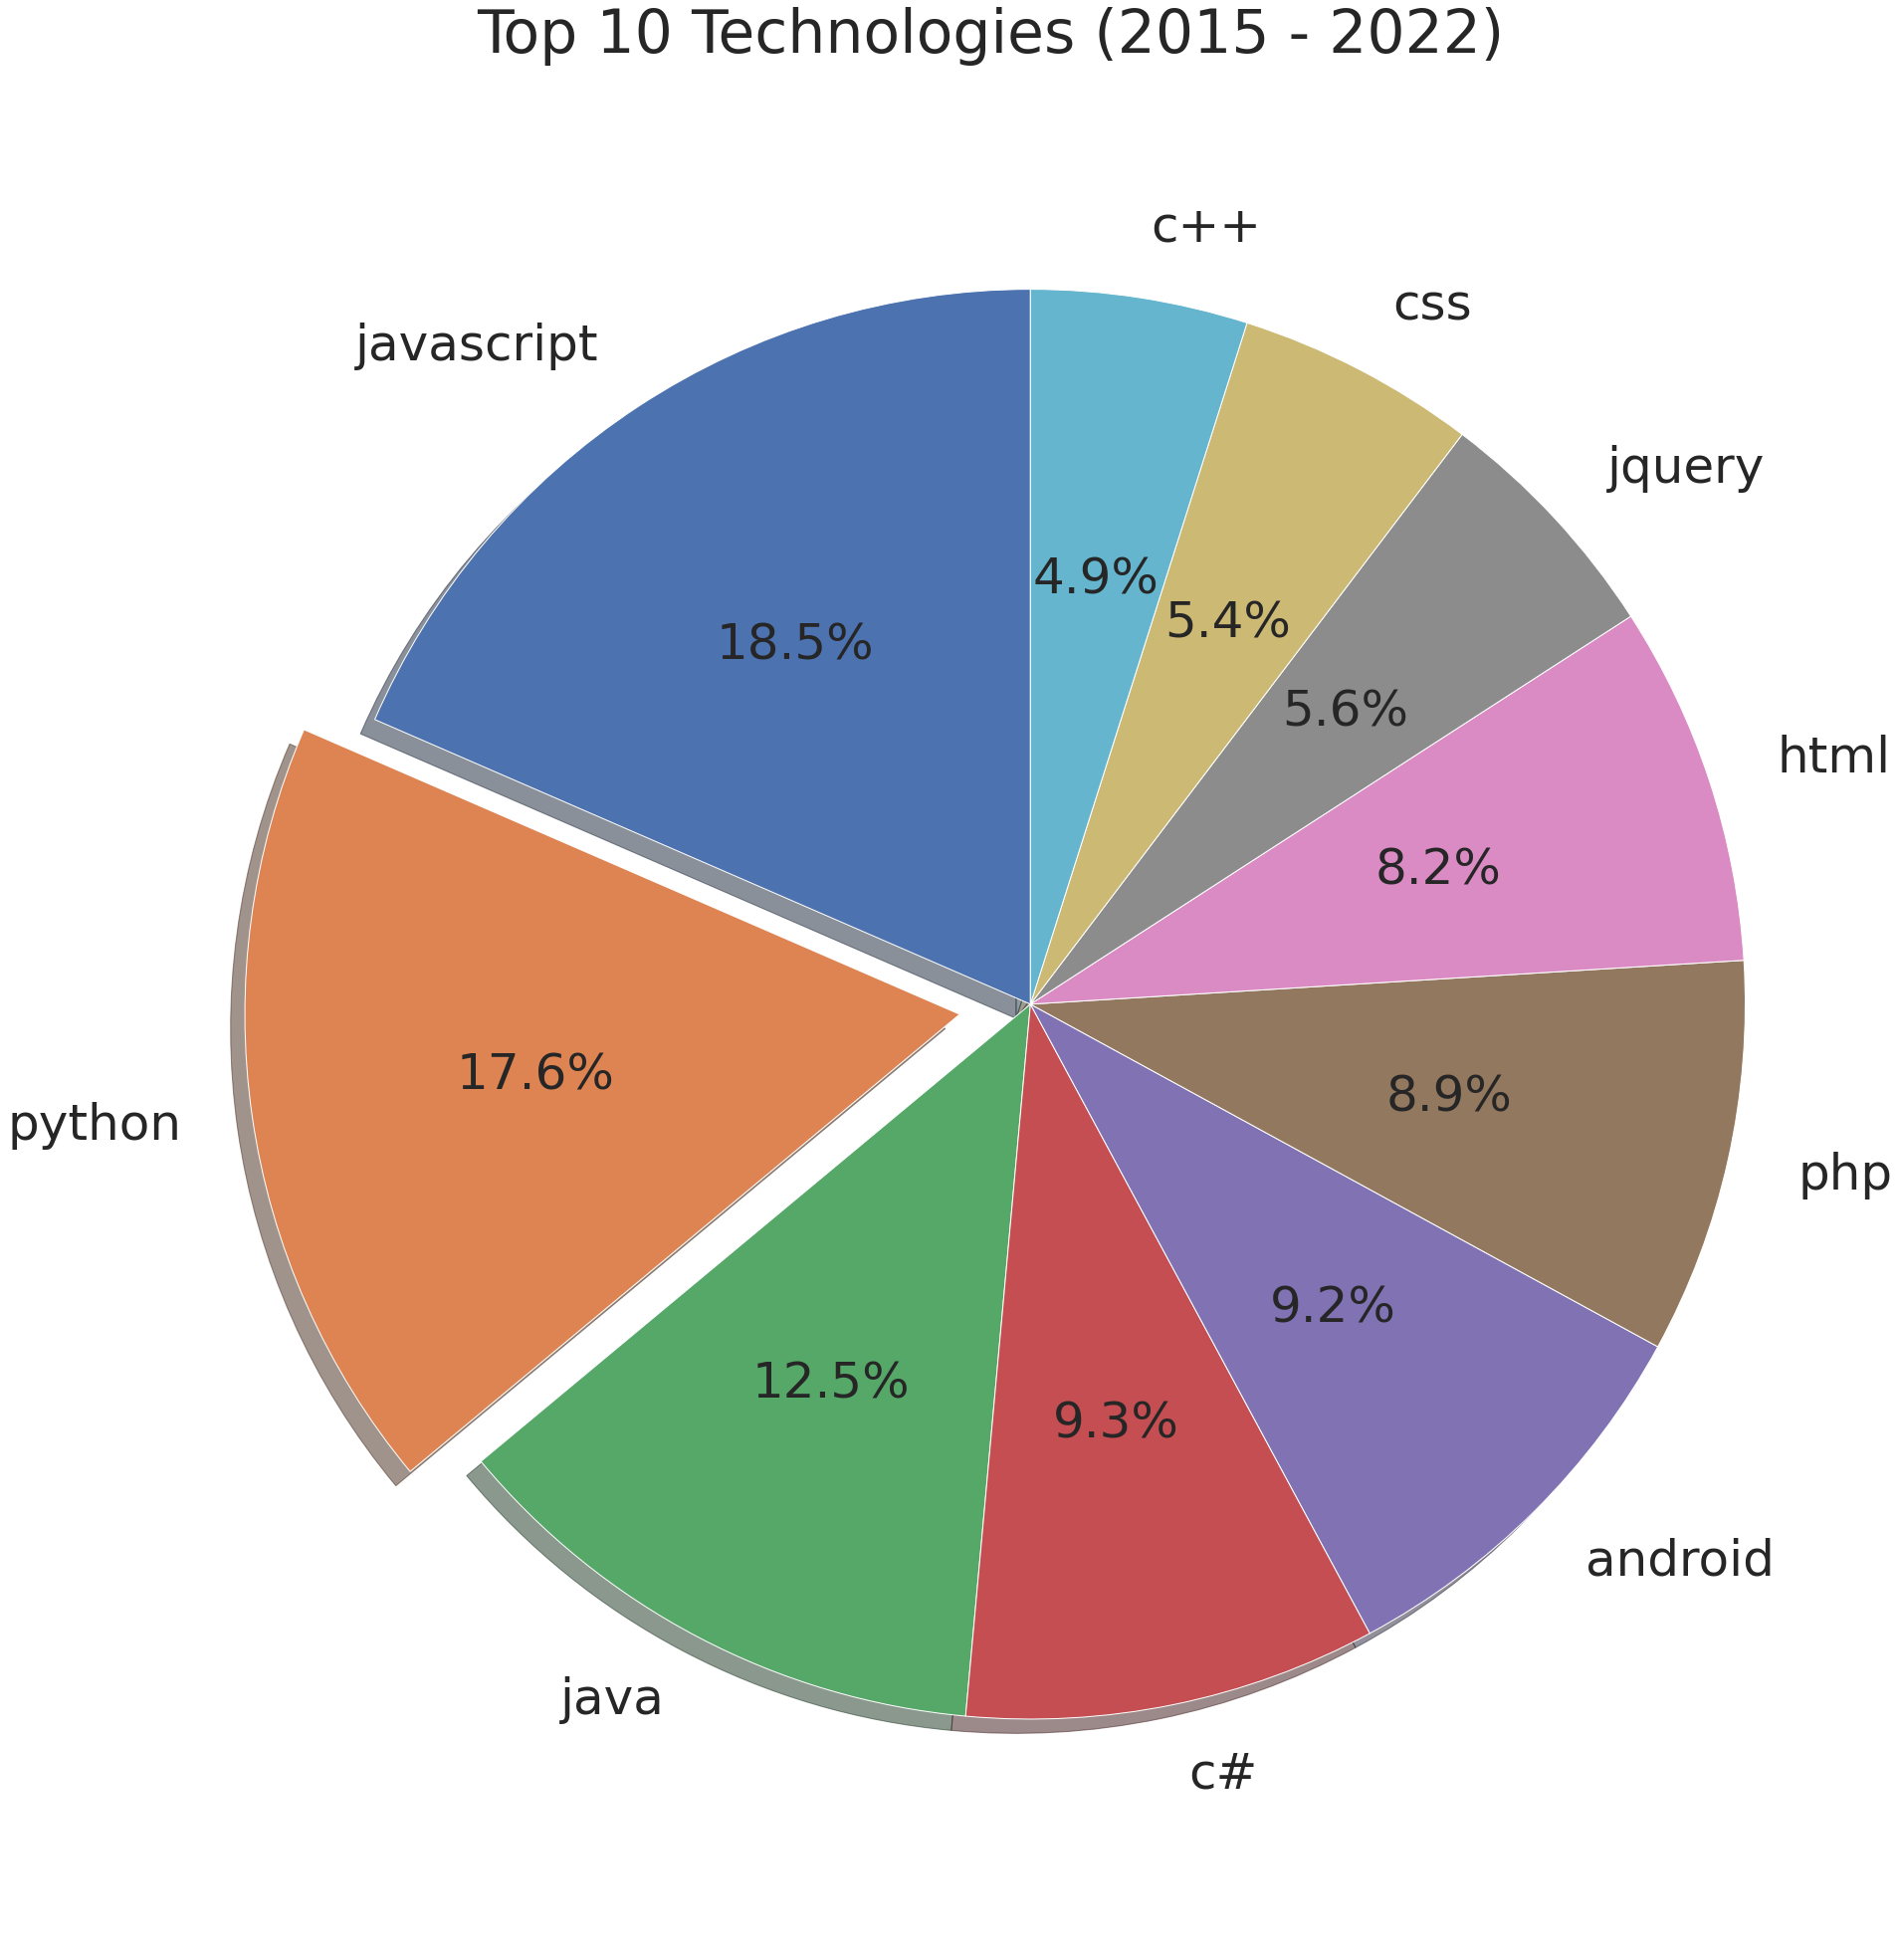

In [11]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = df.tags
sizes = df.percent_share

# "Explode" the 2nd slice (i.e. 'Python')
explode = (0, 0.1, 0, 0, 0, 0, 0, 0, 0, 0) 

# Make pie chart
fig1, ax = plt.subplots(figsize=(30, 35))
ax.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, textprops={'fontsize': 50})

# Equal aspect ratio ensures that pie is drawn as a circle
ax.axis('equal')

# Customize plot
ax.set_title('Top 10 Technologies (2015 - 2022)', fontsize=60)

# Save plot
plt.savefig('tech_distribution_2015.png')

### 2. Toxicity

Another explanation may be that users (especially newer ones) feel increasingly intimidated to post questions, out of fear of being "downvoted" or criticized. 

In [12]:
# Query to select number of positively scored questions over time
query = """
        SELECT
          EXTRACT(YEAR FROM creation_date) AS year,
          COUNT(*) AS num_questions,
          ROUND(SUM(IF(score > 0, 1, 0)) / COUNT(*) * 100, 2) AS percent_positive,
          ROUND(SUM(IF(score < 0, 1, 0)) / COUNT(*) * 100, 2) AS percent_negative
        FROM
          `bigquery-public-data.stackoverflow.posts_questions`
        GROUP BY year
        ORDER BY year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,year,num_questions,percent_positive,percent_negative
0,2008,57755,89.27,0.64
1,2009,342050,73.64,1.18
2,2010,691449,70.77,1.33
3,2011,1191023,64.65,2.25
4,2012,1630810,59.98,3.85
5,2013,2038409,52.24,5.42
6,2014,2141890,45.57,7.06
7,2015,2198514,49.12,7.98
8,2016,2202647,47.44,8.23
9,2017,2118252,45.06,8.79


<Figure size 432x288 with 0 Axes>

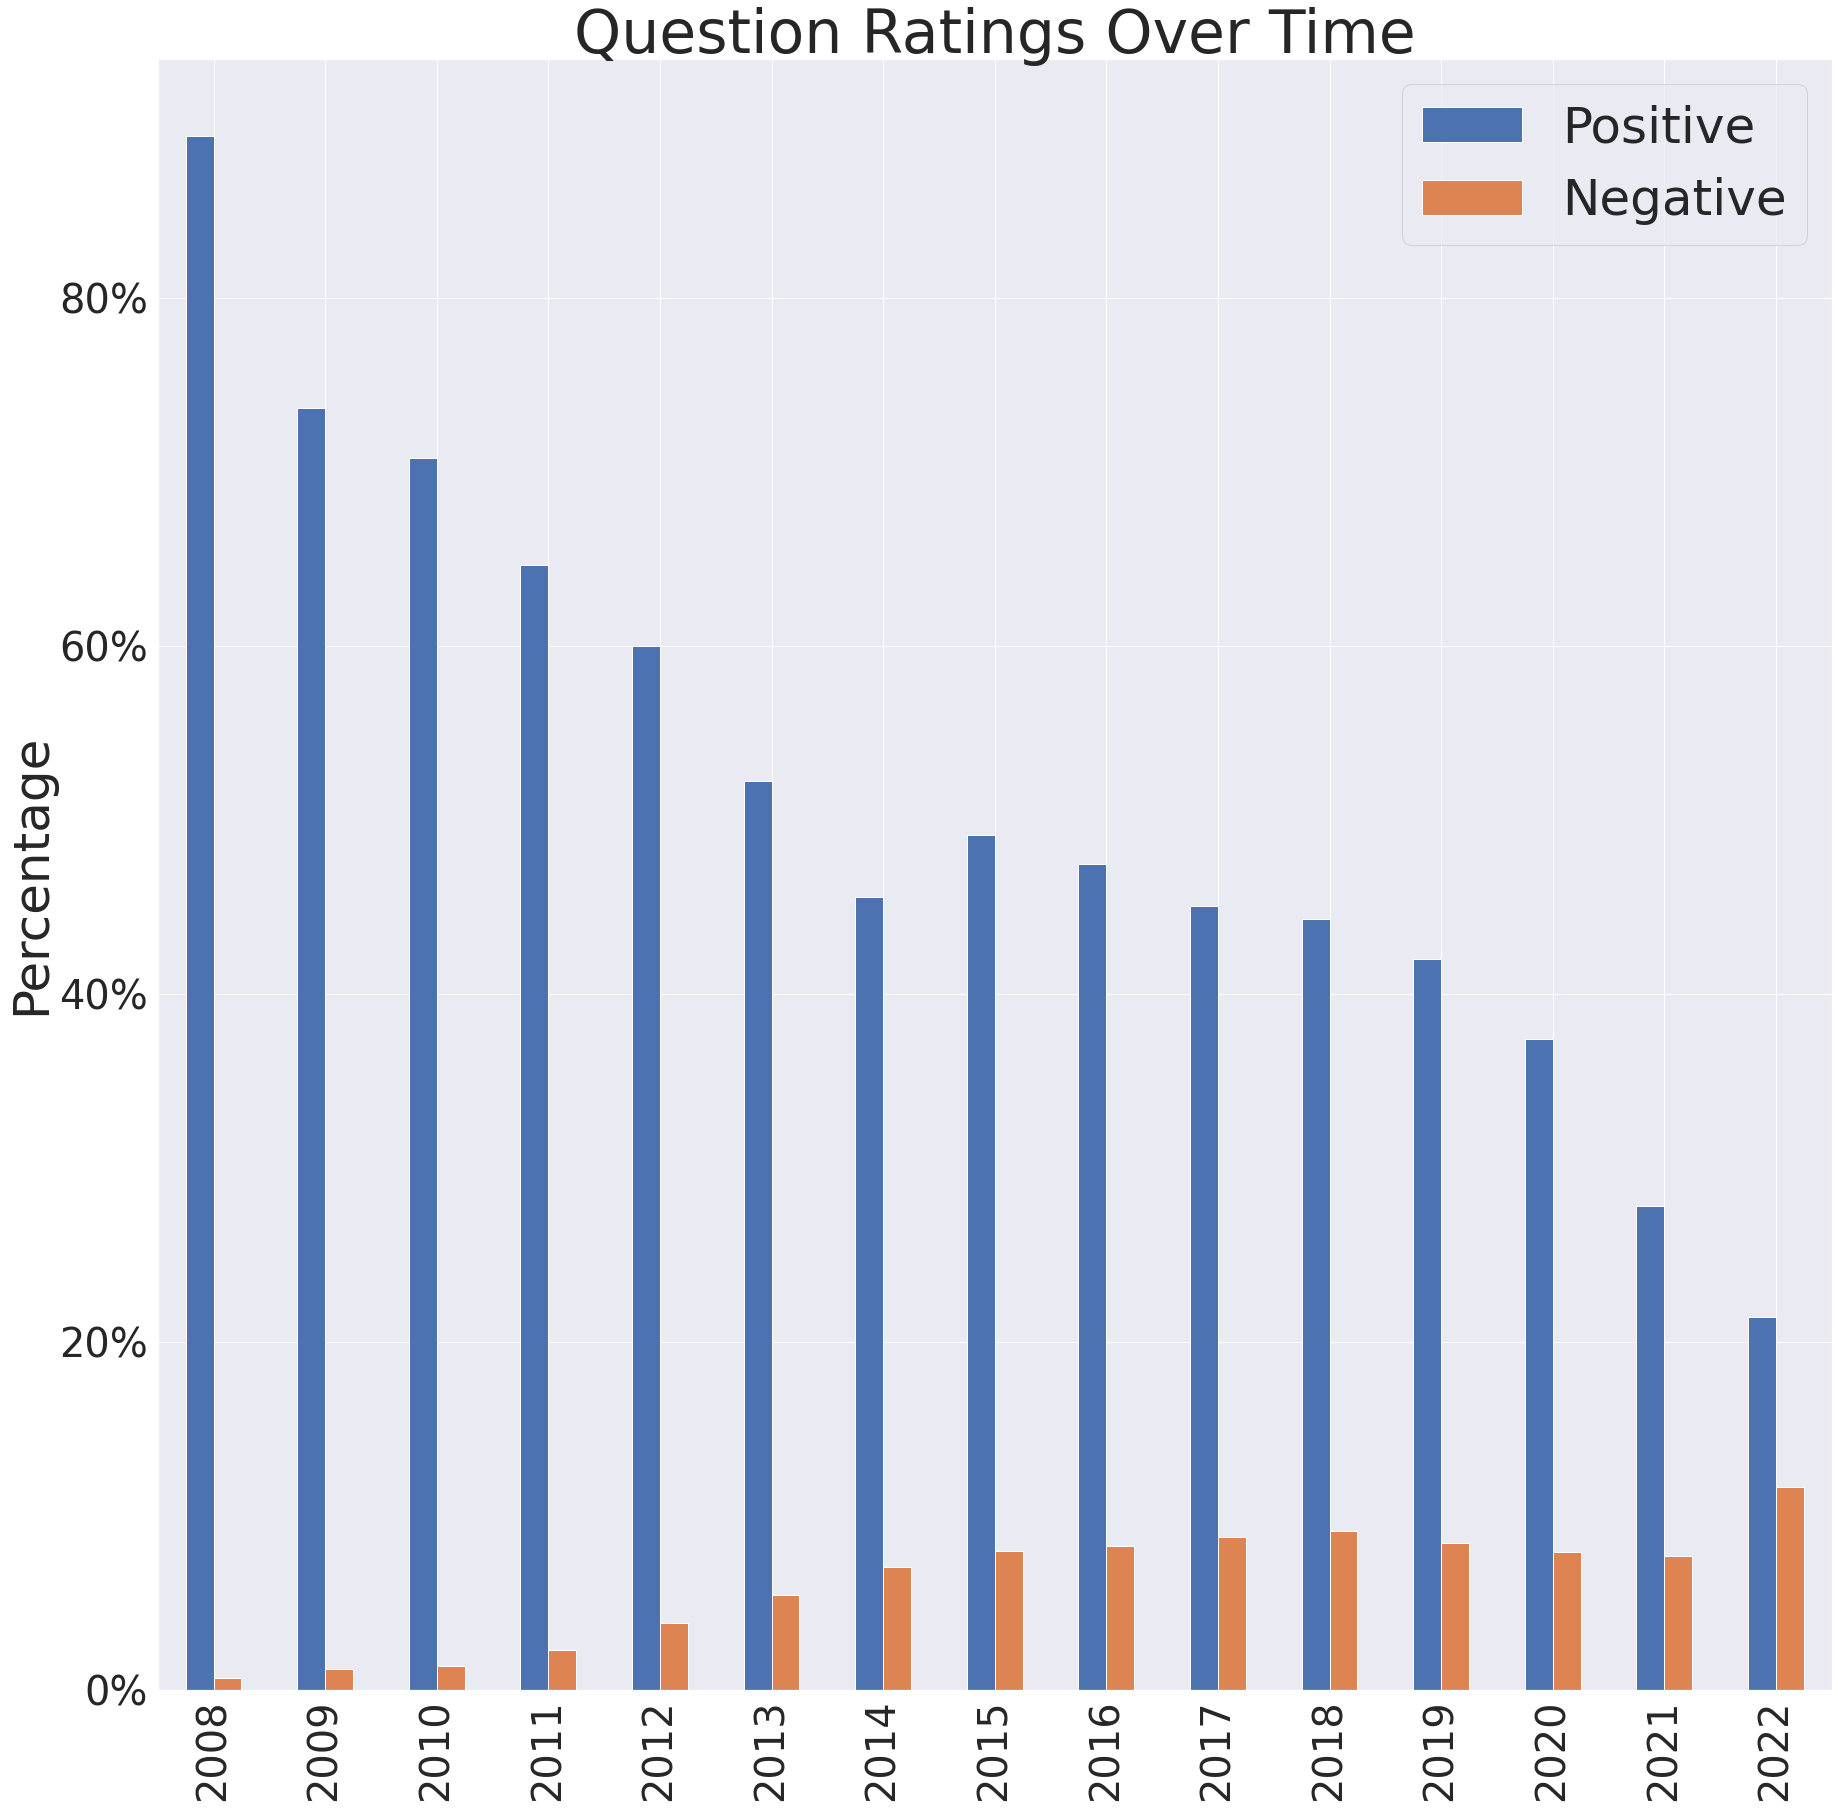

In [13]:
# Make bar plot
fig = plt.figure()
ax = df.plot(x='year', y=['percent_positive', 'percent_negative'], kind='bar', figsize=(30, 30), fontsize=40)

# Customize plot
ax.set_title('Question Ratings Over Time', fontsize=60)
ax.set_xlabel('')
ax.set_ylabel('Percentage', fontsize=50)
ax.set_yticks(ticks=[0, 20, 40, 60, 80], labels=['0%', '20%', '40%', '60%', '80%'])
ax.legend(['Positive', 'Negative'], fontsize=50)

# Save plot
plt.savefig('q_ratings.png')

# Does it matter ? 

In [14]:
# Query to select new_user and inactive_user counts as a function of time
query = """
        WITH cte_1 AS (
            SELECT EXTRACT(YEAR FROM creation_date) AS year, COUNT(*) AS num_new_users
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY year
        ),
        cte_2 AS (
            SELECT 
                c1.year,
                c1.num_new_users,
                ROUND((c1.num_new_users - c2.num_new_users) / c1.num_new_users * 100, 2) AS u_percent_diff
            FROM cte_1 AS c1
            LEFT JOIN cte_1 AS c2
                ON c1.year = c2.year + 1
            ORDER BY c1.year
        ),
        cte_3 AS (
            SELECT 
                EXTRACT(YEAR FROM last_access_date) AS last_accessed_year,
                2022 - EXTRACT(YEAR FROM last_access_date) AS years_inactive,
                COUNT(*) AS num_inactive_users
            FROM `bigquery-public-data.stackoverflow.users`
            GROUP BY last_accessed_year, years_inactive
            ORDER BY last_accessed_year
        )
        SELECT c_2.year, c_2.num_new_users, c_3.num_inactive_users
        FROM cte_2 AS c_2
        JOIN cte_3 AS c_3
            ON c_2.year = c_3.last_accessed_year
        ORDER BY c_2.year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,year,num_new_users,num_inactive_users
0,2008,21640,1629
1,2009,77984,14804
2,2010,199163,88085
3,2011,358656,157644
4,2012,678648,247368
5,2013,1122049,534784
6,2014,1174270,698618
7,2015,1251842,908781
8,2016,1514766,969572
9,2017,1725694,1304404


In [15]:
# Drop 2022 data since it's incomplete
df.drop(index=14, inplace=True)

<Figure size 432x288 with 0 Axes>

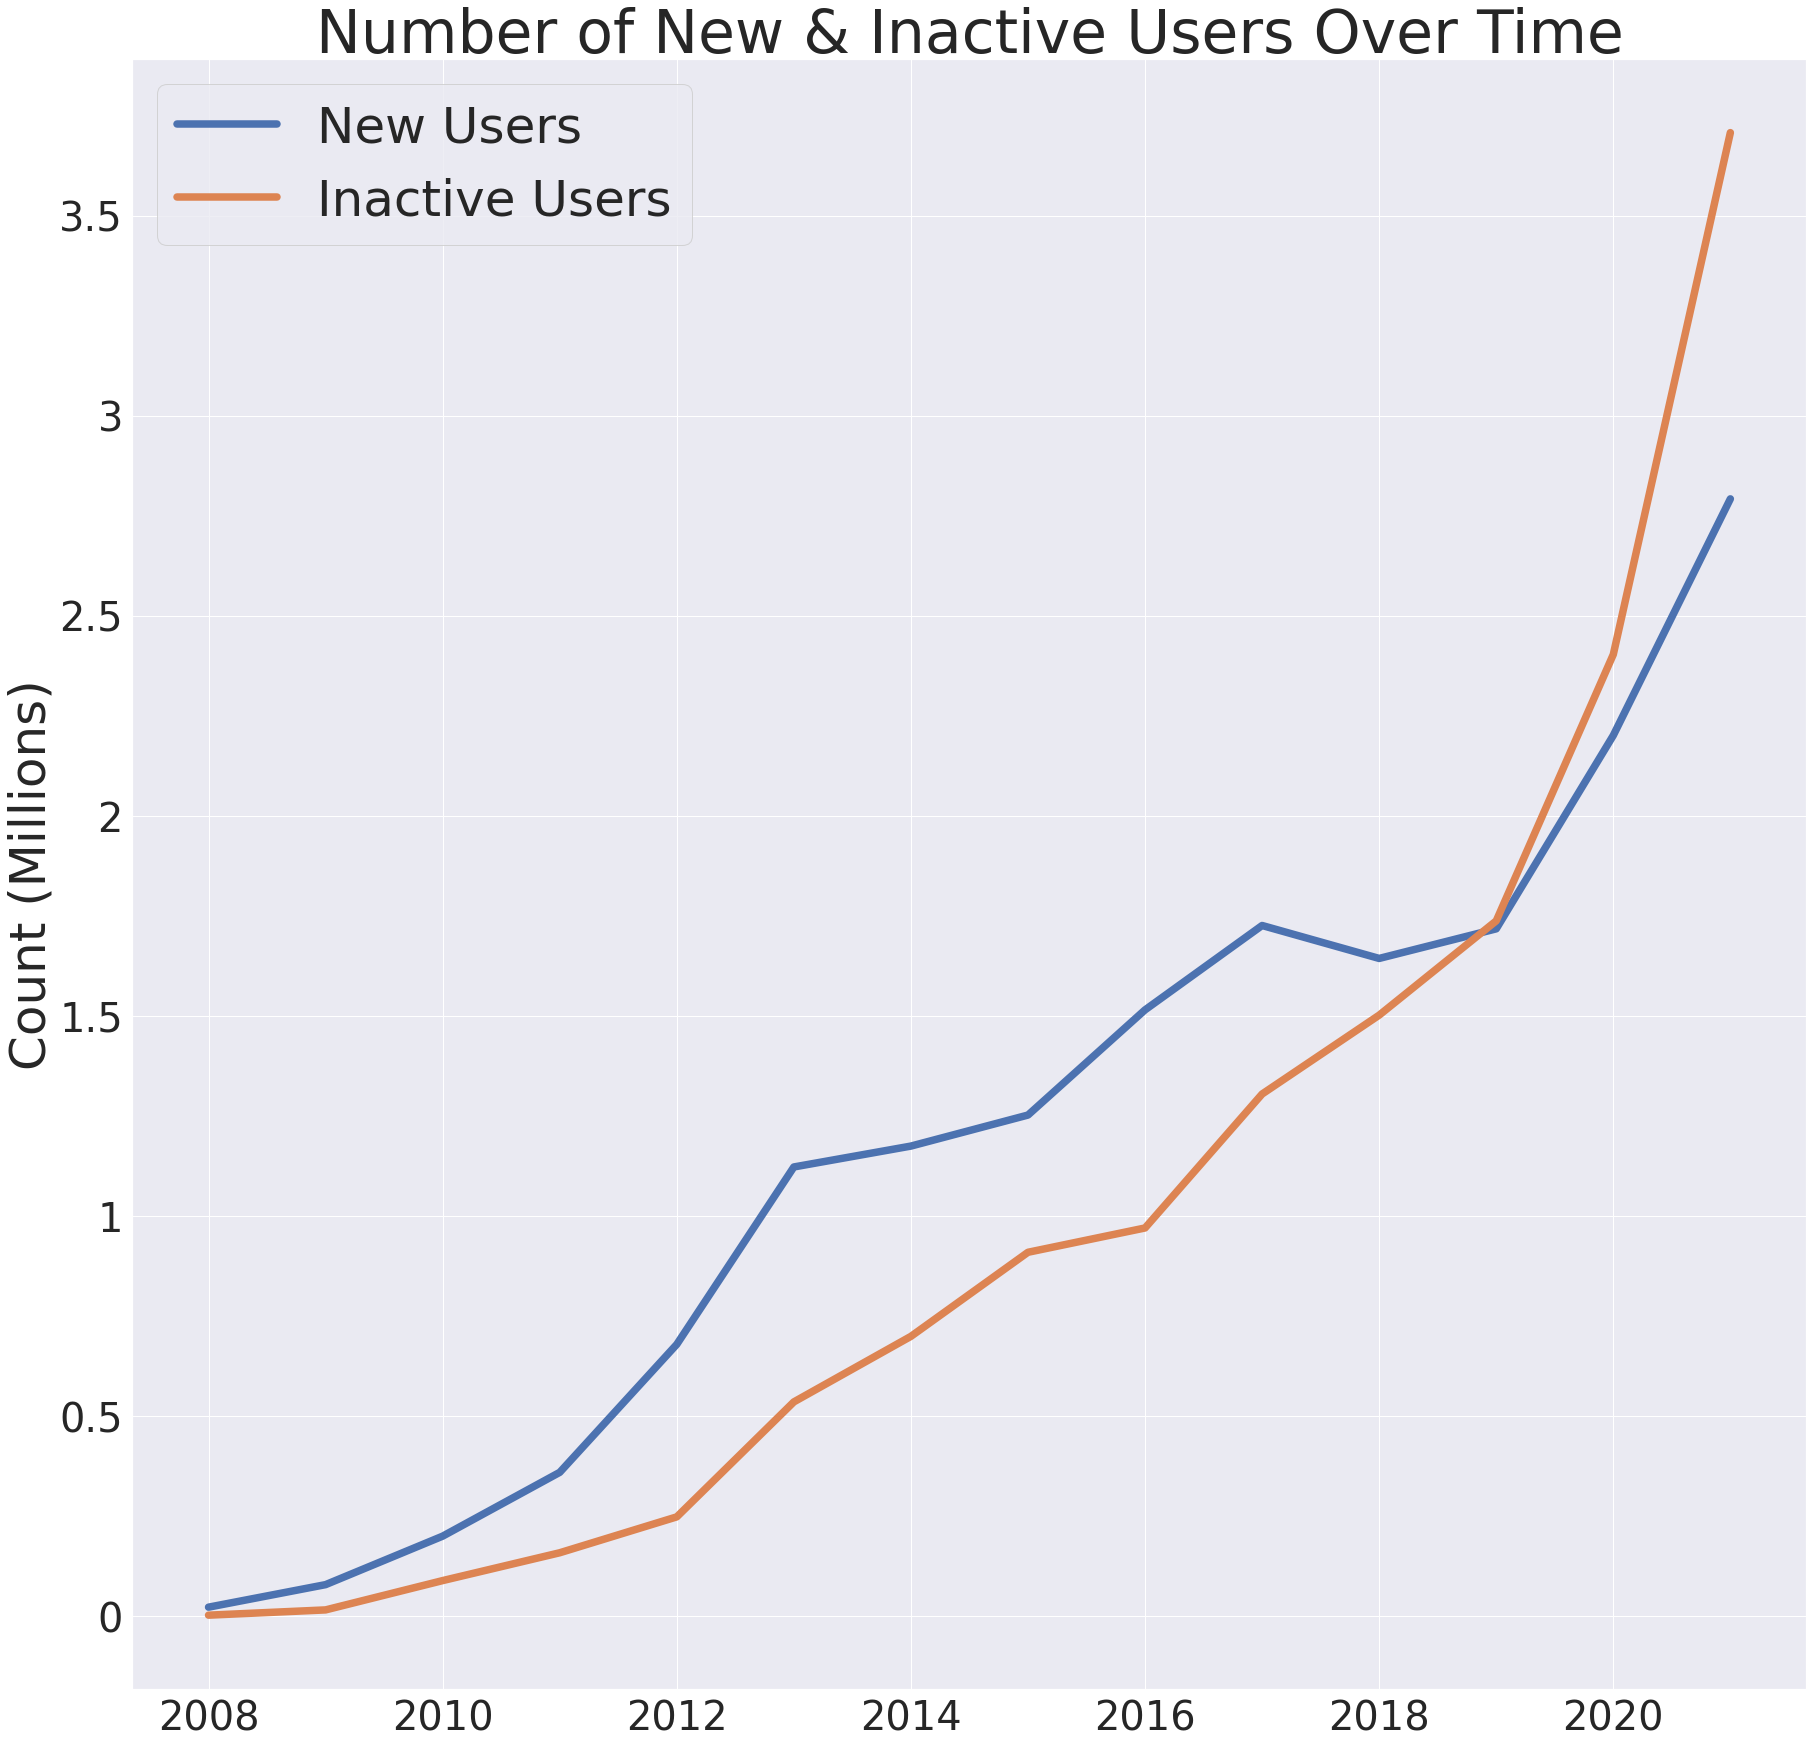

In [16]:
# Make line plot
fig = plt.figure()
ax = df.plot(x='year', y=['num_new_users', 'num_inactive_users'], kind='line', linewidth = 7.5, figsize=(30, 30), fontsize=40)

# Customize plot
ax.set_title('Number of New & Inactive Users Over Time', fontsize=60)
ax.set_xlabel('')
ax.set_ylabel('Count (Millions)', fontsize=50)
ax.set_yticks(ticks=[0, 500000, 1000000, 1500000, 2000000, 2500000, 3000000, 3500000], labels=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5])
ax.legend(['New Users', 'Inactive Users'], fontsize=50)

# Save plot
plt.savefig('user_activity.png')

# Is there room for growth ?

In [17]:
# Query to select avg_questions_per_year as a function of account creation time
query = """
        WITH cte_1 AS (
            SELECT
                u.id,
                EXTRACT(YEAR FROM u.creation_date) AS year,
                COUNT(*) AS num_questions
            FROM `bigquery-public-data.stackoverflow.users` AS u
            LEFT JOIN `bigquery-public-data.stackoverflow.posts_questions` AS q
                ON u.id = q.owner_user_id
            GROUP BY year, u.id
        ),
        cte_2 AS (
            SELECT
                id,
                year,
                num_questions / (2022 - year + 1) AS num_questions_per_year
            FROM cte_1
        )
        SELECT
            year,
            AVG(num_questions_per_year) AS avg_num_questions_per_year
        FROM cte_2
        GROUP BY year
        ORDER BY year
        """

# Set up the query (cancel if greater than 10 GB)
safe_config = bigquery.QueryJobConfig(maximum_bytes_billed=10**10)
query_job = client.query(query, job_config=safe_config)

# API request - run the query, then convert the results to a pandas DataFrame
df = query_job.to_dataframe()

# Print the resulting DataFrame
df

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:440: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


,year,avg_num_questions_per_year
0,2008,1.215314
1,2009,1.037487
2,2010,0.651029
3,2011,0.585034
4,2012,0.408472
5,2013,0.296997
6,2014,0.274722
7,2015,0.275058
8,2016,0.258580
9,2017,0.263021


<Figure size 432x288 with 0 Axes>

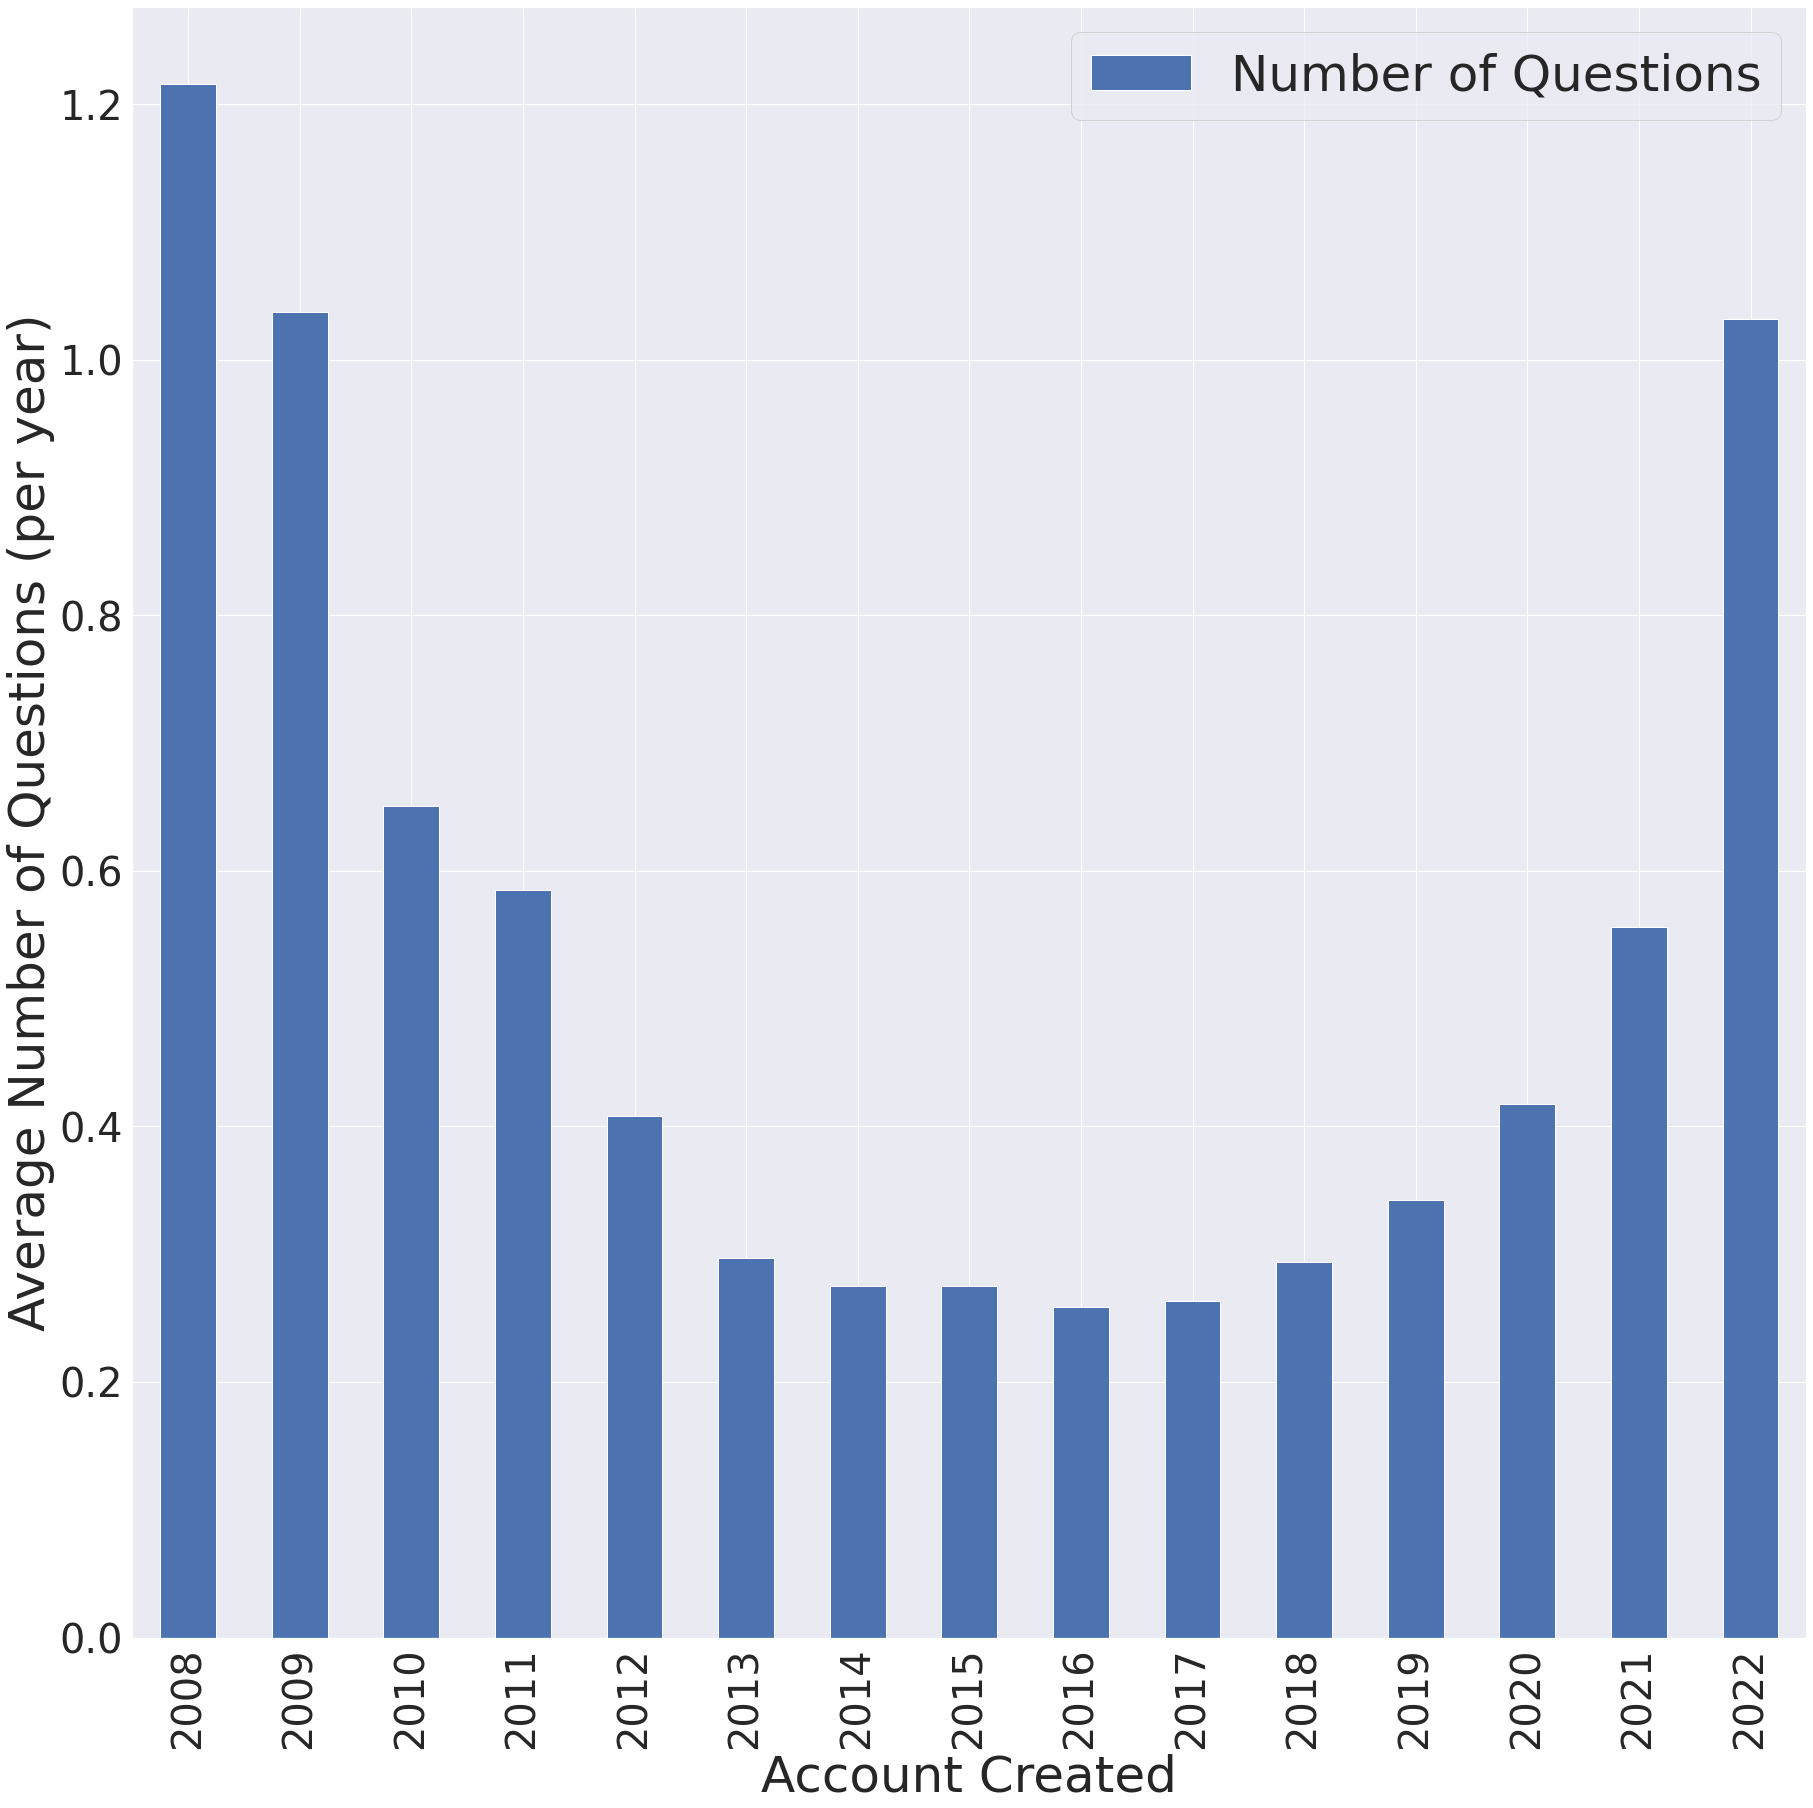

In [18]:
# Make bar plot
fig = plt.figure()
ax = df.plot(x='year', y='avg_num_questions_per_year', kind='bar', figsize=(30, 30), fontsize=40)

# Customize plot
ax.set_xlabel('Account Created', fontsize=50)
ax.set_ylabel('Average Number of Questions (per year)', fontsize=50)
ax.legend(['Number of Questions'], fontsize=50)

# Save plot
plt.savefig('avg_questions_vs_age.png')

---